# Example for HD Module 
This example aim to show the workflow of HD Solver though analytic example from [Antuono (2020)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/triperiodic-fully-threedimensional-analytic-solutions-for-the-navierstokes-equations/0444128148C6D5217F6F78B8C9BB0219) and also explore if MHDflows could resolve turbulence properties.

In [3]:
using MHDFlows
using PyCall,PyPlot
using FFTW,CUDA,Statistics
using LinearAlgebra: mul!, ldiv!

In [4]:
device!(0)
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [5]:
function ProblemGeneratorTG!(prob,L0,U0;N = prob.grid.nx)
  R     = 0;

  # Output Setting  
  kx,ky,kz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  l = 2*π/L0;
    
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    kx[i,j,k] = l*prob.grid.x[i];
    ky[i,j,k] = l*prob.grid.y[j];
    kz[i,j,k] = l*prob.grid.z[k];
  end
    
  pfactor =  4/3*sqrt(2/3);
    
  θ1 = asin(-(√(3)+R)/2/√(1+R^2));
  Φ1 = asin((√(3)-R)/2/√(1+R^2));
  ϕ1 = asin(1/(1+R^2));
    
  ux = @.  U0*pfactor*(sin(kx+θ1)*cos(ky+Φ1)*sin(kz+ϕ1) - cos(kz+θ1)*sin(kx+Φ1)*sin(ky+ϕ1));
  uy = @.  U0*pfactor*(sin(ky+θ1)*cos(kz+Φ1)*sin(kx+ϕ1) - cos(kx+θ1)*sin(ky+Φ1)*sin(kz+ϕ1));
  uz = @.  U0*pfactor*(sin(kz+θ1)*cos(kx+Φ1)*sin(ky+ϕ1) - cos(ky+θ1)*sin(kz+Φ1)*sin(kx+ϕ1));

  #Update V Conponment to Problem
  SetUpProblemIC!(prob; ux = ux, uy = uy, uz = uz);
    
  return nothing
end


ProblemGeneratorTG! (generic function with 1 method)

# Re = 50 Case

In [6]:
#Simulation's parameters
N = 32;
Lx = 2π;
Re = 50;
U0 = 6.5
ν = 2*π*U0/Re;
dt = 1/500;

# Testing the problem
# Declare the problem on GPU
CPUprob  = Problem(CPU();nx = N,
                         Lx = Lx,
                          ν = ν,
                         nν = 1,
           # Timestepper and equation options
                         dt = dt,
                    stepper = "RK4",
           # Float type and dealiasing
                          T = Float32);
CPUprob

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on CPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [7]:
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

KE = MHDFlows.Diagnostic(KEfoo, CPUprob,freq=10);

In [8]:
CUDA.memory_status()
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

Effective GPU memory usage: 11.07% (1.107 GiB/10.000 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)Effective GPU memory usage: 11.07% (1.107 GiB/10.000 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)

In [9]:
# Set up the initial condition
ProblemGeneratorTG!(CPUprob,2π,U0);
TimeIntegrator!(CPUprob,1.0,1000;
                   usr_dt = dt,
                    diags = [KE],
              loop_number = 100,
                     save = false,
                 save_loc = "",
                 filename = "",
                  dump_dt = 0)

n =      100, t =      0.2, KE =   3930.0
n =      200, t =      0.4, KE =   1480.0
n =      300, t =      0.6, KE =    554.0
n =      400, t =      0.8, KE =    208.0
n =      500, t =      1.0, KE =     78.0
Total CPU/GPU time run = 160.24 s, zone update per second = 102450.859 


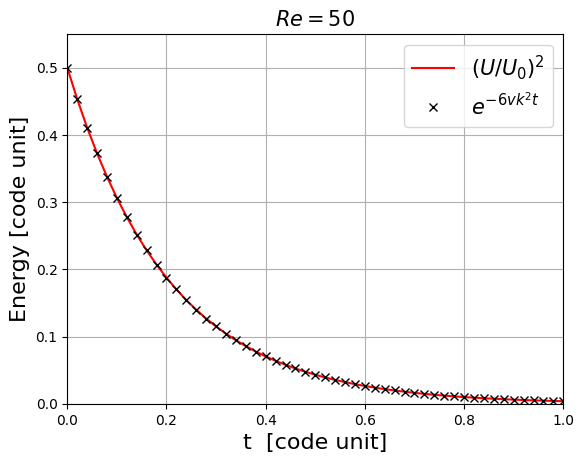

(0.0, 1.0)

In [10]:
#Plotting of KE change
n  = KE.i;
t  = KE.t[1:n];
uu = KE.data[1:n];
dV  = (CPUprob.grid.dx)^3
uu[1] = U0^2*N^3;
nn = length(t)
k² = 1
v0 = 2*π*U0/Re;
plt.plot(t[1:nn],uu/uu[1]/2,"r",label=L"(U/U_0)^2")
plt.plot(t[1:1:nn],1/2*exp.(-6*v0*k²*(t[1:1:nn].-t[1])),"kx",label=L"e^{-6vk^2t}")
plt.title(L"Re ="*string(round(Re)),fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("t  [code unit]",size=16)
plt.ylabel("Energy [code unit]",size=16)
plt.grid()
plt.ylim(0,0.55)
plt.xlim(0,1.0)

# Re = 1000 Case

In [11]:
#Simulation's parameters
N = 32;
Lx = 2π;
Re = 1000;
U0 = 6.5
ν = 2*π*U0/Re;
dt = 1/500;

# Testing the problem
# Declare the problem on GPU
CPUprob  = Problem(CPU();nx = N,
                         Lx = Lx,
                          ν = ν,
                         nν = 1,
           # Timestepper and equation options
                         dt = dt,
                    stepper = "RK4",
           # Float type and dealiasing
                          T = Float32);
CPUprob

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on CPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [12]:
# Set up the initial condition
ProblemGeneratorTG!(CPUprob,2π,U0);
KE = Diagnostic(KEfoo, CPUprob,freq=10);

# Set up the initial condition
TimeIntegrator!(CPUprob,9.0,5000;
                   usr_dt = dt,
                    diags = [KE],
              loop_number = 500,
                     save = false,
                 save_loc = "",
                 filename = "",
                  dump_dt = 0)

n =      500, t =      1.0, KE =   8200.0
n =     1000, t =      2.0, KE =   6420.0
n =     1500, t =      3.0, KE =   5020.0
n =     2000, t =      4.0, KE =   3930.0
n =     2500, t =      5.0, KE =   3080.0
n =     3000, t =      6.0, KE =   2410.0
n =     3500, t =      7.0, KE =   1890.0
n =     4000, t =      8.0, KE =   1480.0
n =     4500, t =      9.0, KE =   1150.0
Total CPU/GPU time run = 1457.469 s, zone update per second = 101195.098 


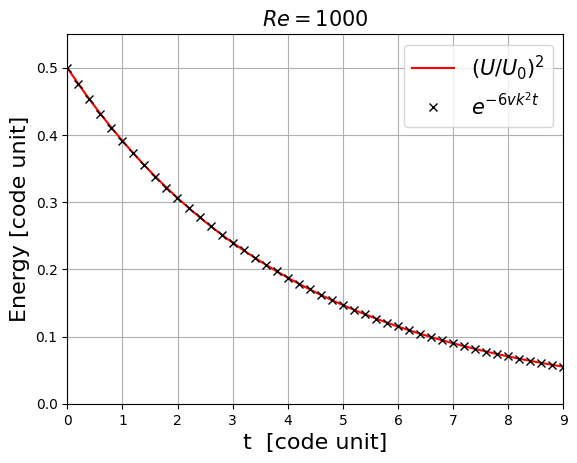

(0.0, 9.0)

In [13]:
#Plotting of KE change
n  = KE.i;
t  = KE.t[1:n];
uu = KE.data[1:n];
uu[1] = U0^2*N^3;
nn = length(t)
k² = 1
v0 = 2*π*U0/Re;
plt.plot(t[1:nn],uu[1:nn]/uu[1]/2,"r",label=L"(U/U_0)^2")
plt.plot(t[1:10:nn],1/2*exp.(-6*v0*k²*(t[1:10:nn].-t[1])),"kx",label=L"e^{-6vk^2t}")
plt.title(L"Re ="*string(round(Re)),fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("t  [code unit]",size=16)
plt.ylabel("Energy [code unit]",size=16)
plt.grid()
plt.ylim(0,0.55)
plt.xlim(0,9.0)

### Diference between MHDFlow and  Antuono (2020).
Instability doesn't arises from our simulation at Re = 1000, but we are always further check if instability happens in higher Re case with higher resolution

In [14]:
#Simulation's parameters
N  = 150;
Lx = 2π;
Re = 5000;
U0 = 6.5
ν  = 2*π*U0/Re;
dt = 1/500;

# Testing the problem
# Declare the problem on GPU
GPUprob  = Problem(GPU();nx = N,
                         Lx = Lx,
                          ν = ν,
                         nν = 1,
           # Timestepper and equation options
                         dt = dt,
                    stepper = "RK4",
           # Float type and dealiasing
                          T = Float32);
GPUprob

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [15]:
CUDA.memory_status()
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

Effective GPU memory usage: 16.44% (1.644 GiB/10.000 GiB)
Memory pool usage: 435.679 MiB (512.000 MiB reserved)Effective GPU memory usage: 16.44% (1.644 GiB/10.000 GiB)
Memory pool usage: 435.679 MiB (512.000 MiB reserved)

In [16]:
# Set up the initial condition
ProblemGeneratorTG!(GPUprob,2π,U0);
KE = Diagnostic(KEfoo, GPUprob,freq=10);

t0 = 8
# Actaul computation
TimeIntegrator!(GPUprob,12.0,10000;
                   usr_dt = dt,
                    diags = [KE],
              loop_number = 500,
                     save = false,
                 save_loc = "",
                 filename = "",
                  dump_dt = 0)

n =      500, t =      1.0, KE =   9980.0
n =     1000, t =      2.0, KE =   9500.0
n =     1500, t =      3.0, KE =   9050.0
n =     2000, t =      4.0, KE =   8610.0
n =     2500, t =      5.0, KE =   8200.0
n =     3000, t =      6.0, KE =   7780.0
n =     3500, t =      7.0, KE =   6540.0
n =     4000, t =      8.0, KE =   2940.0
n =     4500, t =      9.0, KE =    955.0
n =     5000, t =     10.0, KE =    433.0
n =     5500, t =     11.0, KE =    255.0
n =     6000, t =     12.0, KE =    171.0
Total CPU/GPU time run = 287.897 s, zone update per second = 7.0349284019e7 


From Re~5000 case, we observe the instability behaviour in our solver at t ~ 6.5

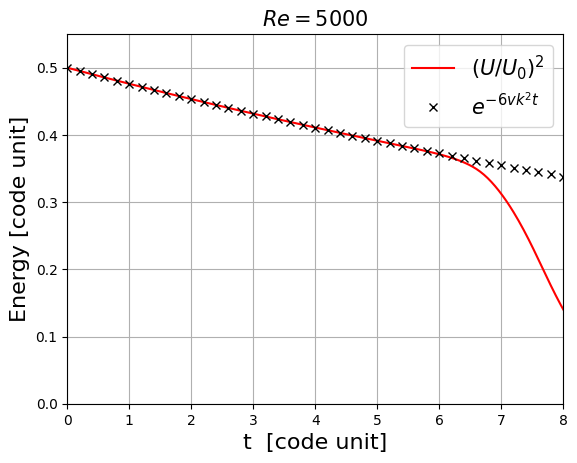

(0.0, 8.0)

In [17]:
#Plotting of KE change
n  = KE.i;
t  = KE.t[1:n];
uu = KE.data[1:n];
uu[1] = U0^2*N^3;
nn = length(t)
k² = 1
v0 = 2*π*U0/Re;
plt.plot(t[1:nn],uu[1:nn]/uu[1]/2,"r",label=L"(U/U_0)^2")
plt.plot(t[1:10:nn],1/2*exp.(-6*v0*k²*(t[1:10:nn].-t[1])),"kx",label=L"e^{-6vk^2t}")
plt.title(L"Re ="*string(round(Re)),fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("t  [code unit]",size=16)
plt.ylabel("Energy [code unit]",size=16)
plt.grid()
plt.ylim(0,0.55)
plt.xlim(0,8.0)

To see if the instability caused by turbulence, we check its spectrum and strcuture in below.

In [18]:
#Spectrun Function
uxc = Array(GPUprob.vars.ux);
uyc = Array(GPUprob.vars.uy);
uzc = Array(GPUprob.vars.uz);
Ek = uxc.^2 + uyc.^2 + uzc.^2;
y,x = spectralline(Ek);

## Conclusion
One can see the structure of velocity become fully chaotic from its initial state (LHS figure) while a power law relationship can be observed for the energy spectrum (RHS figure). We may safety say the Tri-periodic vortrex settup caused at instability in high Re and a turbulence behaviour is captured by the MHDFlow solver, in particalar both its structure and its powerlaw spectrum.


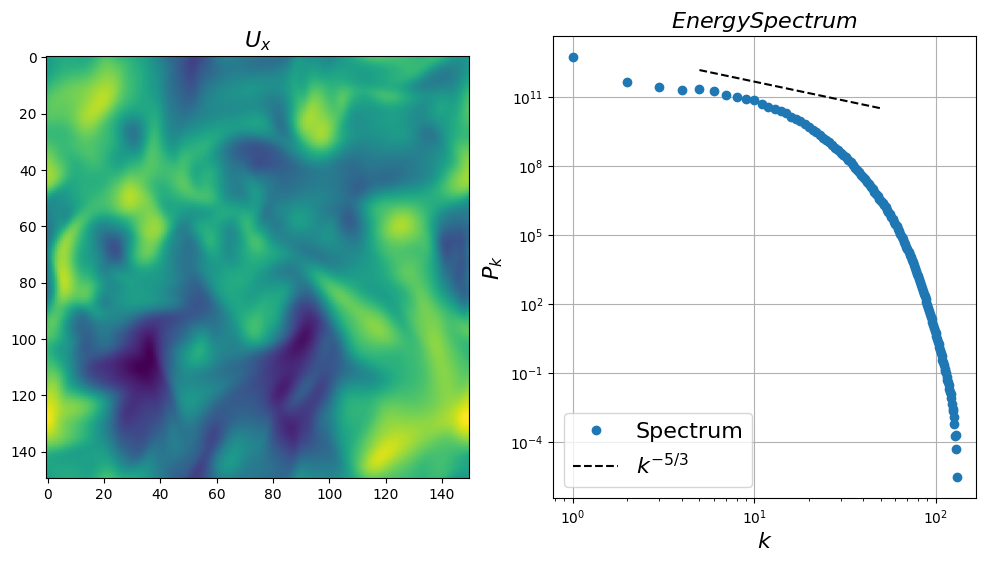

PyObject <matplotlib.legend.Legend object at 0x7fee8035fdd8>

In [19]:
figure(figsize=(12,6))
subplot(121)
imshow(uxc[:,:,5])
title(L"U_x",size=16)
subplot(122)
loglog(x,y,"o",label="Spectrum");
loglog(x[5:50],y[5]*x[5:50].^(-5/3)*100,"k--",label=L"k^{-5/3}")
ylabel(L"P_k}",size=16)
xlabel(L"k",size=16)
title(L"Energy Spectrum",size=16)
grid()
legend(fontsize=16)